### impporting libraries

In [52]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
     



#### Constants

In [53]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Loading dataset

In [54]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    r"C:\Users\andis\Desktop\smalldata",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19934 files belonging to 15 classes.


In [55]:
len(dataset)

623

# Exploratory Data Analysis

In [56]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy']

Found 41552 files belonging to 23 classes.


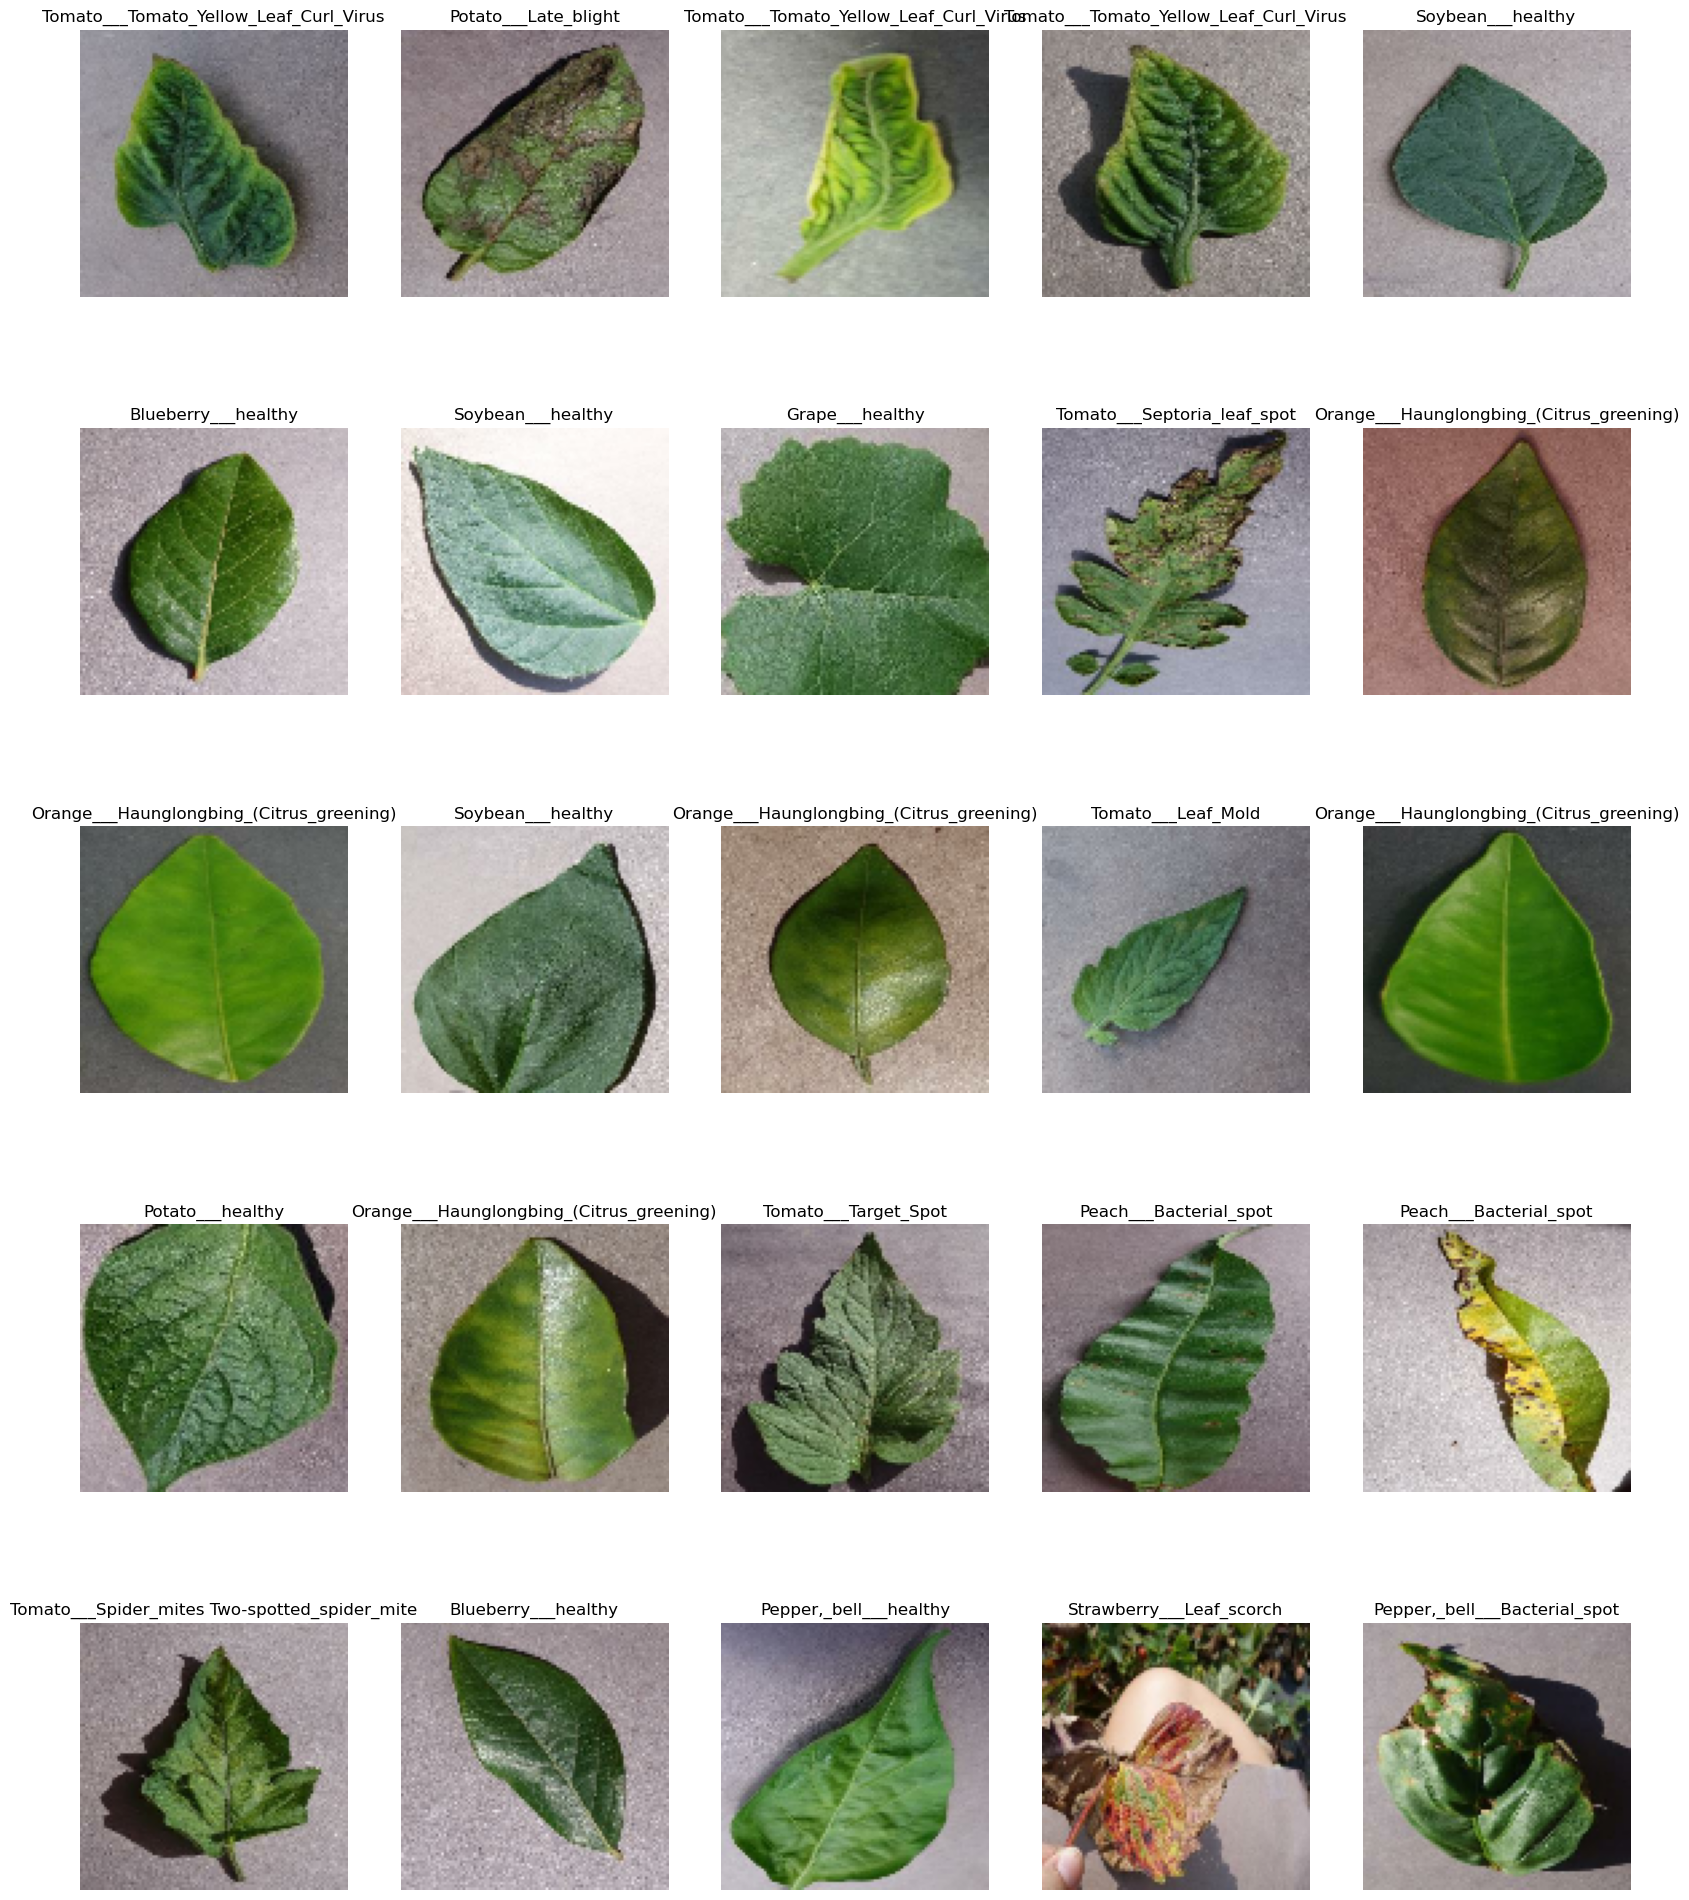

In [57]:
# visualize sample images
attribute = image_dataset_from_directory(r"C:\Users\andis\Desktop\Plant_leave_diseases_dataset_with_augmentation", image_size=(100,100))
plt.figure(figsize=(20,25))
for image, labels in attribute.take(1):
  for i in range (25):
    plt.subplot(5,5, i + 1)
    plt.imshow(np.array(image[i]).astype("uint8"))
    plt.title(attribute.class_names[labels[i]])
    plt.axis("off")

In [58]:
for image_batch, labels_batch in dataset.take(5):
    print(image_batch.shape)
    print(labels_batch.numpy)
          ## it shows number images in each batch with is 32 every image has a size of 32x32 and
          ## 3 shows RGB the color -> channel =3 comes from this

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([10,  5,  3,  2,  8, 12,  7,  0, 14,  1,  0,  4,  6,  4, 14, 12, 14,
        0, 14,  7,  1,  4, 13, 12, 12,  3,  5, 11,  6, 11, 12, 14])>>
(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 5, 11,  3,  9,  9, 12,  9,  8, 13,  7,  1, 14,  6, 12, 10, 14,  0,
        4, 10,  3,  8,  4, 12,  4,  5,  1,  1, 14,  0,  3,  4,  8])>>
(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 4,  4, 13, 11, 11,  2,  2,  2,  1, 14, 14,  2,  8,  2, 12, 14, 10,
       11,  7,  1,  6,  4, 12,  8,  9, 12, 13,  8, 12,  3,  3, 14])>>
(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([11, 14,  7, 14,  4,  0,  6,  2,  5,  0,  6, 13, 12,  4, 13,  2,  1,
        9,  1,  1,  4, 11,  4, 13, 14,  2,  4, 12,  2,  5, 13, 12])>>
(32, 256

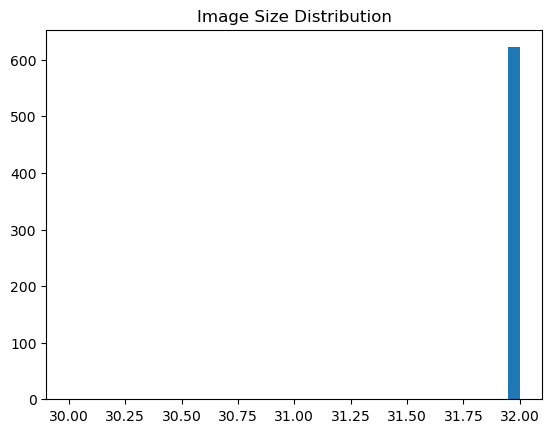

In [59]:
#Class Distribution:
sizes = [len(image) for image, _ in dataset]
plt.hist(sizes, bins=39)
plt.title("Image Size Distribution")
plt.show()

#### Image Segmentation:
Apply image segmentation techniques, such as watershed segmentation or superpixel methods, to partition images into meaningful regions. Extract features from each segment.

In [60]:
from skimage.segmentation import slic
from skimage.color import rgb2lab

def image_segmentation_features(image):
    segments = slic(image, n_segments=100, compactness=10, sigma=1)
    avg_color = np.mean(image, axis=(0, 1))
    segment_colors = [np.mean(image[segments == i], axis=(0, 1)) for i in np.unique(segments)]
    color_diffs = [np.linalg.norm(avg_color - segment_color) for segment_color in segment_colors]
    return color_diffs


# Data Cleaning:

In [61]:
# Check for missing values in the dataset
missing_values = sum([tf.reduce_sum(tf.cast(tf.math.is_nan(image_batch), tf.int32)) for image_batch, _ in dataset.take(1)])
print("Missing Values:", missing_values.numpy())


Missing Values: 0


In [62]:
# Check for outliers in image sizes
outliers = [size for size in sizes if size > 1000] 
print("Outliers:", outliers) #check for outlier pixles

Outliers: []


In [63]:
# Check for and remove duplicates
unique_images = set()
duplicates = 0
for image_batch, _ in dataset:
    for img in image_batch.numpy():
        img_hash = hash(img.tobytes())
        if img_hash in unique_images:
            duplicates += 1
        else:
            unique_images.add(img_hash)

print("Number of Duplicates:", duplicates)

Number of Duplicates: 210


## Data preprocessing

In [64]:
len(dataset)

623

In [65]:
''' 80% ==> training
20% ==> test ( 10% test; 10% validation) '''

' 80% ==> training\n20% ==> test ( 10% test; 10% validation) '

In [66]:
train_size = 0.8
len(dataset)*train_size

498.40000000000003

In [67]:
train_dataset = dataset.take(498)
len(train_dataset)

498

In [69]:
test_dataset = dataset.skip(498) # skiping first 1st 1537 data and take the rest.
len(test_dataset)

125

In [70]:
validation_size=0.1
len(dataset)*validation_size

62.300000000000004

In [71]:
validation_dataset = test_dataset.take(62)
len(validation_dataset)

62

In [72]:
test_dataset = test_dataset.skip(62)
len(test_dataset)

63

In [73]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * dataset_size)
    validation_size = int(val_split * dataset_size)
    
    train_dataset = dataset.take(train_size)    
    validation_datset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, validation_dataset, test_dataset

In [74]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [75]:
len(train_dataset)

498

In [76]:
len(validation_dataset)

62

In [77]:
len(test_dataset)

63

In [78]:
# optimizing data to run fast while training 

In [79]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [80]:
import tensorflow as tf

# Assuming train_dataset and test_dataset are instances of tf.data.Dataset

# Get the number of elements in the datasets
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()

print("Train dataset size:", train_dataset_size)
print("Test dataset size:", test_dataset_size)

Train dataset size: 498
Test dataset size: 63


In [81]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [82]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### building the model 

In [83]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [84]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 39

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

#### Learning Rate Scheduler:
You can use a learning rate scheduler to adjust the learning rate during training. This can help in faster convergence and better model performance.

In [86]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * 0.9 ** epoch)

optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=optimizer,  # Fix the indentation here
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=50,
    callbacks=[lr_schedule]  
)

Epoch 1/50
498/498 [==============================] - 430s 858ms/step - loss: 0.8317 - accuracy: 0.7197 - val_loss: 0.6270 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 2/50
498/498 [==============================] - 422s 848ms/step - loss: 0.5380 - accuracy: 0.8230 - val_loss: 0.5397 - val_accuracy: 0.8382 - lr: 9.0000e-04
Epoch 3/50
498/498 [==============================] - 417s 838ms/step - loss: 0.4150 - accuracy: 0.8600 - val_loss: 0.9674 - val_accuracy: 0.7172 - lr: 8.1000e-04
Epoch 4/50
498/498 [==============================] - 419s 841ms/step - loss: 0.3448 - accuracy: 0.8828 - val_loss: 0.6707 - val_accuracy: 0.7888 - lr: 7.2900e-04
Epoch 5/50
498/498 [==============================] - 424s 851ms/step - loss: 0.2905 - accuracy: 0.9023 - val_loss: 0.3466 - val_accuracy: 0.8947 - lr: 6.5610e-04
Epoch 6/50
498/498 [==============================] - 420s 843ms/step - loss: 0.2508 - accuracy: 0.9180 - val_loss: 0.4117 - val_accuracy: 0.8644 - lr: 5.9049e-04
Epoch 7/50
498/498 [======

In [ ]:
# training model
from tensorflow.keras.callbacks import EarlyStopping
%time

project = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = validation_dataset, callbacks= callbacks)


#### testing model on test dataset

In [87]:
scores = model.evaluate(test_dataset)

63/63 [==============================] - 92s 265ms/step - loss: 0.0507 - accuracy: 0.9856


In [88]:
scores

[0.05070188641548157, 0.985615074634552]

# Plotting the Accuracy and Loss Curves

In [89]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 498}

In [90]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [91]:
type(history.history['loss'])

list

In [92]:
len(history.history['loss'])

50

In [94]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8317192196846008,
 0.5380228161811829,
 0.41504526138305664,
 0.3447682857513428,
 0.2905462682247162]

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

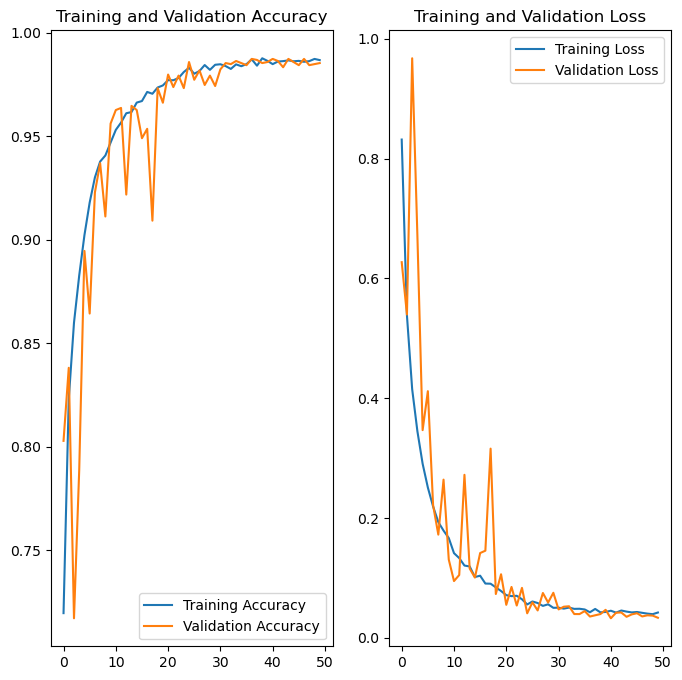

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Apple___Black_rot
1/1 [==============================] - 0s 437ms/step
predicted label: Apple___Black_rot


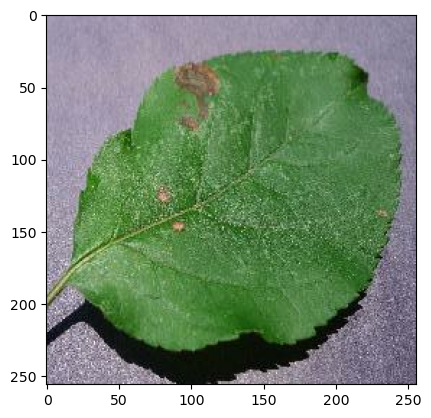

In [97]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [99]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


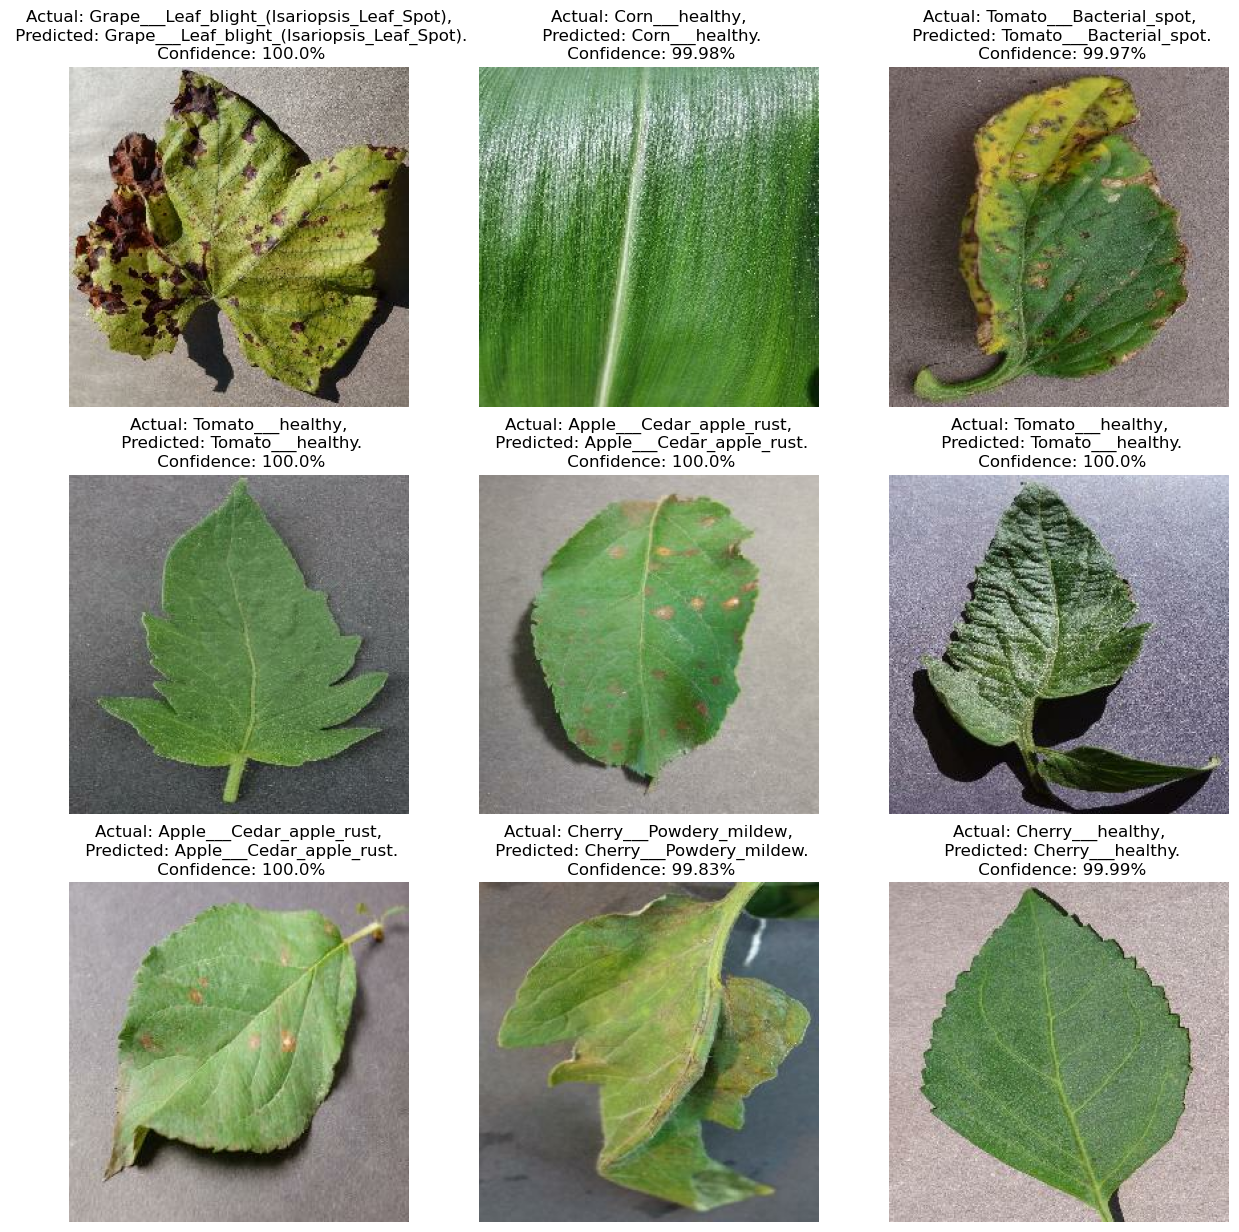

In [100]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [133]:
import os
model_version=1 
model.save(f"C:/Users/andis/Desktop/Fronrier_Tech_leaders/Capstone Project/AgriGuard Smart Crop Health Management/CNN1{1}")

INFO:tensorflow:Assets written to: C:/Users/andis/Desktop/Fronrier_Tech_leaders/Capstone Project/AgriGuard Smart Crop Health Management/CNN11\assets


INFO:tensorflow:Assets written to: C:/Users/andis/Desktop/Fronrier_Tech_leaders/Capstone Project/AgriGuard Smart Crop Health Management/CNN11\assets
